In [29]:
import collections
import itertools
import json
import os
import re
import glob
import operator

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

In [30]:
def compute_accuracy(rows):
    levels = ['easy', 'medium', 'hard', 'extra', 'all']
    total = collections.defaultdict(int)
    exact = collections.defaultdict(int)
    for row in rows:
        exact[row['hardness']] += row['exact']
        exact['all'] += row['exact']
        total[row['hardness']] += 1
        total['all'] += 1
    
    result = {hardness: exact[hardness] / total[hardness]
              for hardness in levels}
    result = {**result, **{'{} count'.format(hardness): total[hardness] for hardness in levels}}
    return result

In [35]:
accuracy_per_run = collections.defaultdict(dict)
rows = []
for d in sorted(glob.glob('../logdirs/spider-idioms/nl2code-0518/*')):
    exp_name = os.path.basename(d)
    filt, cov, nt = exp = re.match('filt-([^_]+)_st-([^_]+)_nt-([^_]+)', exp_name).groups()

    eval_paths = glob.glob(os.path.join(d, 'eval-val-step*-bs1.jsonl'))
    all_scores = []
    best = (0, 0)
    for eval_path in eval_paths:
        step = int(re.search('step(\d+)', eval_path).group(1))
        scores = json.load(open(eval_path))
        first_half_exact = compute_accuracy(scores['per_item'][:517])
        second_half_exact = compute_accuracy(scores['per_item'][517:])
        all_scores.append((step, scores['total_scores']['all']['exact'], first_half_exact['all'], second_half_exact['all']))
    
    all_scores.sort(key=operator.itemgetter(0))
    sorted_scores = sorted(all_scores, reverse=True, key=operator.itemgetter(1))
    rows.append(exp +  (len(eval_paths),) + (sorted_scores[0] if sorted_scores else (-1, -1, -1, -1)))
    accuracy_per_run[exp_name] = {
        'x': [s[0] for s in all_scores],
        'all': [s[1] for s in all_scores],
        '1/2': [s[2] for s in all_scores],
        '2/2': [s[3] for s in all_scores],
    }
    print(d)
    
df = pd.DataFrame(rows, columns=('filt', 'cov', 'nt', 'num steps eval', 'step', 'acc', '1/2 acc', '2/2 acc'))

../logdirs/spider-idioms/nl2code-0518/filt-none_st-cov-examples_nt-40
../logdirs/spider-idioms/nl2code-0518/filt-none_st-cov-examples_nt-80
../logdirs/spider-idioms/nl2code-0518/filt-none_st-cov-xent_nt-40
../logdirs/spider-idioms/nl2code-0518/filt-none_st-cov-xent_nt-80


In [36]:
df

,filt,cov,nt,num steps eval,step,acc,1/2 acc,2/2 acc
0,none,cov-examples,40,17,14100,0.357834,0.367505,0.348162
1,none,cov-examples,80,17,15100,0.365571,0.379110,0.352031
2,none,cov-xent,40,36,33100,0.406190,0.415861,0.396518
3,none,cov-xent,80,22,20100,0.372340,0.384913,0.359768


In [37]:
for k in sorted(accuracy_per_run):
    a = accuracy_per_run[k]
    print(k)
    print(list(zip(a['x'], a['all'])))
    print()

filt-none_st-cov-examples_nt-40
[(100, 0.0), (1100, 0.0), (2100, 0.019342359767891684), (2900, 0.0851063829787234), (3100, 0.10348162475822051), (4100, 0.18181818181818182), (5100, 0.21663442940038685), (6100, 0.27562862669245647), (7100, 0.26595744680851063), (8100, 0.2765957446808511), (9100, 0.3114119922630561), (10100, 0.31431334622823986), (11100, 0.3191489361702128), (12100, 0.32978723404255317), (13100, 0.34622823984526113), (14100, 0.3578336557059961), (15100, 0.3491295938104449)]

filt-none_st-cov-examples_nt-80
[(100, 0.0), (1100, 0.0009671179883945841), (2100, 0.01644100580270793), (2800, 0.07640232108317214), (3100, 0.09284332688588008), (4100, 0.19245647969052224), (5100, 0.24758220502901354), (6100, 0.26595744680851063), (7100, 0.27949709864603484), (8100, 0.29497098646034814), (9100, 0.32205029013539654), (10100, 0.3239845261121857), (11100, 0.3481624758220503), (12100, 0.35106382978723405), (13100, 0.35493230174081236), (14100, 0.36363636363636365), (15100, 0.3655705996

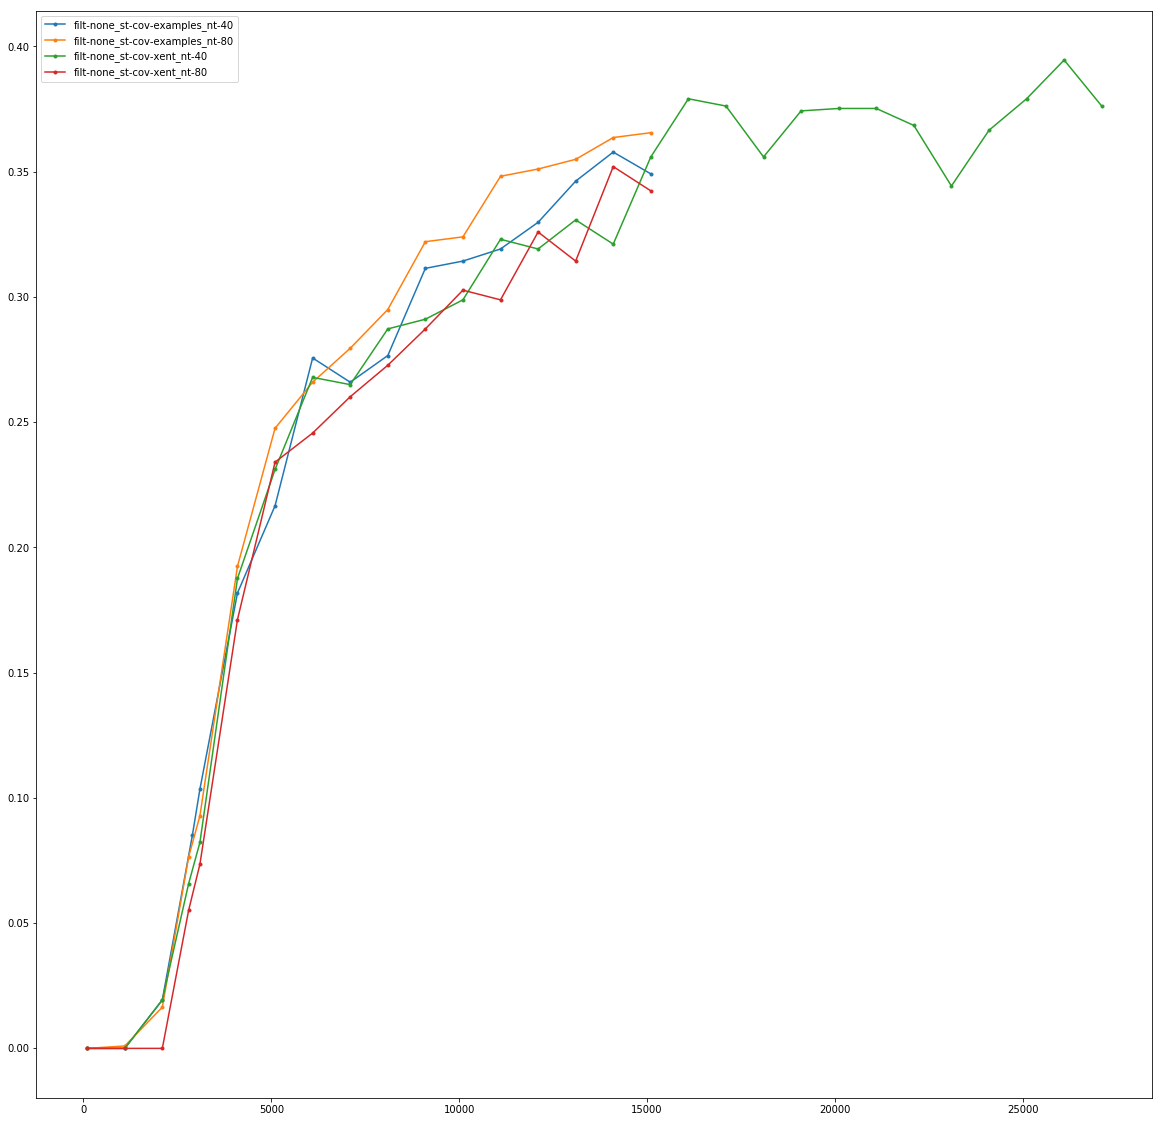

In [34]:
# See how accuracy varies over time
for k, v in sorted(accuracy_per_run.items()):
    plt.plot(v['x'], v['all'], marker='.', label=k)
plt.legend()